In [1]:
!nvidia-smi

Fri Oct 29 06:52:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ps -aux|grep python

root          55  0.0  0.1 160868 42440 ?        S    07:42   0:04 python3 /usr/local/bin/colab-fileshim.py
root          80  0.3  0.2 202608 66936 ?        Sl   07:42   0:40 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root          92 88.8 17.3 33215212 4636748 ?    Ssl  08:08 172:36 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-46047afb-1067-4e8b-9ed2-4470c8d89593.json
root         114  0.3  0.0 129176 16760 ?        Sl   08:08   0:44 /usr/bin/python3 /usr/local/lib/python3.7/dist-packages/debugpy/adapter --for-server 40437 --host 127.0.0.1 --port 20036 --server-access-token 7021b9282b49b1629f802219974aa9f5b2964d4d2de235ceeccde2489fba30f5
root         413  0.0  0.0  18380  3032 ?        S    08:09   0:00 bash -c tail -n +0 -F "/root/.config/Google/DriveFS/Logs/drive_fs.txt" | python3 /opt/google/drive/drive-filter.py > "/root/.config/G

In [ ]:
!kill -9 92

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/HW1/hw1_data.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: p1_data/val_50/5_480.png  
  inflating: p1_data/val_50/5_484.png  
  inflating: p1_data/val_50/6_469.png  
  inflating: p1_data/val_50/6_475.png  
  inflating: p1_data/val_50/6_485.png  
  inflating: p1_data/val_50/6_490.png  
  inflating: p1_data/val_50/6_495.png  
  inflating: p1_data/val_50/7_481.png  
  inflating: p1_data/val_50/7_486.png  
  inflating: p1_data/val_50/7_495.png  
  inflating: p1_data/val_50/7_496.png  
  inflating: p1_data/val_50/8_483.png  
  inflating: p1_data/val_50/8_494.png  
  inflating: p1_data/val_50/8_495.png  
  inflating: p1_data/val_50/8_498.png  
  inflating: p1_data/val_50/9_463.png  
  inflating: p1_data/val_50/9_467.png  
  inflating: p1_data/val_50/9_493.png  
  inflating: p1_data/val_50/10_450.png  
  inflating: p1_data/val_50/11_450.png  
  inflating: p1_data/val_50/11_464.png  
  inflating: p1_data/val_50/11_469.png  
  inflating: p1_data/val_50/11_479.png  
  inflating: p1_data/val_50/11_485.png  
  inflating: 

In [ ]:

!cp /content/drive/MyDrive/HW1/model/inv3.pth /content/

In [ ]:
!python3 /content/hw1_2.py /content/test_data /content/pred_list

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
!python3 hw1_1.py '/content/p1_data/val_50' '123.csv'

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100% 104M/104M [00:01<00:00, 81.7MB/s] 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [3]:
# Import necessary packages.
import os
import pandas as pd
import numpy as np
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
import torch
import random
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance, ImageOps
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from tqdm import tqdm

# Create correspondence between category and rgb

In [4]:
classes = ['urban', 'agriculture', 'rangeland', 'forest', 'water', 'barren', 'unknown']

# RGB color for each class
colormap = [[0,255,255], [255,255,0], [255,0,255], [0,255,0], [0,0,255], [255,255,255], [0,0,0]]

len(classes), len(colormap)

(7, 7)

# Labeling

In [5]:
# https://zhuanlan.zhihu.com/p/32506912
cm2lbl = np.zeros(256**3)
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i

def image2label(im):
    data = np.array(im, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return np.array(cm2lbl[idx], dtype='int64')

# Data Augmentation

In [6]:
!mkdir /content/train_data
!mkdir /content/train_label

!mkdir /content/test_data
!mkdir /content/test_label

imgname = os.listdir('/content/p2_data/train')

# Classify labels and data
data_sat = {}
data_mask = {}
for i in imgname:
  if i.split('.')[-1] == 'jpg':
    data_sat[i] = int(i.split('_')[0])
  else:
    data_mask[i] = int(i.split('_')[0])   
sat_dataframe = pd.DataFrame(list(data_sat.items()), columns=['sat', 'label'])
mask_dataframe = pd.DataFrame(list(data_mask.items()), columns=['mask', 'label'])
label_dataframe = pd.merge(sat_dataframe, mask_dataframe)
label_dataframe = label_dataframe.sort_values(by='label')
label_dataframe['label'] = label_dataframe['sat'].apply(lambda x: x.split('_')[0])
print(label_dataframe)

# We apply 6 times of RandomCrop(file name use crop to describe) on each image and also crop the same region on ground truth image.
for img in tqdm(range(len(label_dataframe))):
  path = '/content/p2_data/train/'
  sat_image = Image.open(path + '%s_sat.jpg'%str(label_dataframe['label'].iloc[img]))
  mask_image = Image.open(path + '%s_mask.png'%str(label_dataframe['label'].iloc[img]))

  for k in range(6):
    i, j, h, w = transforms.RandomCrop.get_params(mask_image, output_size=(256, 256))
    torchvision.transforms.functional.crop(mask_image, i, j, h, w).save('/content/train_label/%s_crop_%s'%(str(img), str(k)+'_mask.png'))
    torchvision.transforms.functional.crop(sat_image, i, j, h, w).save('/content/train_data/%s_crop_%s'%(str(img), str(k)+'_sat.jpg'))

  trans = transforms.Compose([transforms.Resize((256, 256))])
  trans(mask_image).save('/content/train_label/%s_resize_mask.png'%str(img))
  trans(sat_image).save('/content/train_data/%s_resize_sat.jpg'%str(img))

  trans = transforms.Compose([transforms.Resize((256, 256)),transforms.RandomHorizontalFlip(p = 1)])
  trans(mask_image).save('/content/train_label/%s_hflip_mask.png'%str(img))
  trans(sat_image).save('/content/train_data/%s_hflip_sat.jpg'%str(img))

  trans = transforms.Compose([transforms.Resize((256, 256)),transforms.RandomVerticalFlip(p=1)])
  trans(mask_image).save('/content/train_label/%s_vflip_mask.png'%str(img))
  trans(sat_image).save('/content/train_data/%s_vflip_sat.jpg'%str(img))
  
  trans = transforms.Compose([transforms.Resize((256, 256)),transforms.RandomHorizontalFlip(p = 1), transforms.RandomVerticalFlip(p=1)])
  trans(mask_image).save('/content/train_label/%s_hvflip_mask.png'%str(img))
  trans(sat_image).save('/content/train_data/%s_hvflip_sat.jpg'%str(img))

path = '/content/p2_data/validation'
obj_path = '/content/test_data'
label_path = '/content/test_label'
for i in os.listdir('/content/p2_data/validation'):
  if i.split('.')[-1] == 'jpg':
    os.rename(os.path.join(path, i), os.path.join(obj_path, i))
  else:
    os.rename(os.path.join(path, i), os.path.join(label_path, i))

In [18]:
print('Number of training data: ', len(os.listdir('/content/train_data')))
print('Number of training label: ', len(os.listdir('/content/train_label')))
print('Number of validation data: ', len(os.listdir('/content/test_data')))
print('Number of validation label: ', len(os.listdir('/content/test_label')))

Number of training data:  20000
Number of training label:  20000
Number of validation data:  257
Number of validation label:  257


In [14]:
# !rm -r /content/test_data
# !rm -r /content/test_label
# !rm -r /content/train_data
# !rm -r /content/train_label
# !rm -r /content/p1_data
# !rm -r /content/p2_data

In [7]:
train_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_tfm = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
import pandas as pd
import os
import torch as t
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import skimage.transform
import numpy


TRAIN_ROOT = '/content/train_data'
TRAIN_LABEL = '/content/train_label'
TEST_ROOT = '/content/test_data' 
TEST_LABEL = '/content/test_label' 

train_imgs = os.listdir(TRAIN_ROOT)
train_imgs = [os.path.join(TRAIN_ROOT, img) for img in train_imgs]
train_imgs.sort()

train_labels = os.listdir(TRAIN_LABEL)
train_labels = [os.path.join(TRAIN_LABEL, label) for label in train_labels]
train_labels.sort()

test_imgs = os.listdir(TEST_ROOT)
test_imgs = [os.path.join(TEST_ROOT, img) for img in test_imgs]
test_imgs.sort()

test_labels = os.listdir(TEST_LABEL)
test_labels = [os.path.join(TEST_LABEL, label) for label in test_labels]
test_labels.sort()


name_value = classes
num_class = 7

class Image_Dataset(Dataset):
    def __init__(self, train=True, trans=None, labeling=None):
        self.train = train
        self.train_imgs = train_imgs
        self.train_labels = train_labels
        self.test_imgs = test_imgs
        self.test_labels = test_labels

        if self.train:
            self.imgs = self.train_imgs
            self.labels = self.train_labels
        else:
            self.imgs = self.test_imgs
            self.labels = self.test_labels

        self.transform = trans
        self.labeling = labeling

    def __getitem__(self, index):
        img = self.imgs[index]
        label = self.labels[index]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')

        # Randomly rotae image 
        if self.train:
          randomly = np.random.random()
          if randomly > 0.5:
            angle = [20, 30, 35, 40, 45, 55, 65, 75]
            select_angle = np.random.choice(angle)
            img = transforms.functional.rotate(img, int(select_angle))
            label = transforms.functional.rotate(label, int(select_angle))
          else:
            pass

        else:
          pass

        img = self.transform(img)
        label = self.labeling(label)
        sample = {'img': img, 'label': label}

        return sample

    def __len__(self):
        return len(self.imgs)

batch_size = 8
train_set = Image_Dataset(True, train_tfm, image2label)
valid_set = Image_Dataset(False, train_tfm, image2label)

train_data = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=6, pin_memory=True)
val_data = DataLoader(valid_set, batch_size=2, shuffle=True, num_workers=1, pin_memory=True)

In [9]:
import torchvision
from torchvision import models
import torch

def initialize_model(input_size, num_classes, use_pretrained=True):
    """ DeepLabV3 pretrained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
    """
    model_deeplabv3 = models.segmentation.deeplabv3_resnet101(pretrained=use_pretrained, progress=True)
    model_deeplabv3.aux_classifier = None
    model_deeplabv3.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

    return model_deeplabv3

In [20]:

from tqdm import tqdm
from torch import optim
from torch.autograd import Variable
from datetime import datetime
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch as t


n_classes = len(classes)

net= initialize_model(256, num_classes=n_classes, use_pretrained=True)
net = net.cuda()

# Loading previous model
try:
 net.load_state_dict(t.load('/content/drive/MyDrive/HW1/model/Deeplab_5.pth'))
 net = net.cuda()
 print('Loading previous model successful')
except:
 pass

criterion = nn.NLLLoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=6e-5)

total_epoch = 1

# We save the model which have lowest validation loss
# best = {0.3016637665934341: 5, 0.30216322043665156: 2, 0.3047810095513976: 3}
best = {500:1, 200:2, 300:3}
accum_iter = 4

for epoch in range(total_epoch):

    # We apply learning rate schedule. The learning rate is reduced by half after every 10 epoch training
    if epoch % 10 == 0 and epoch != 0:
        for group in optimizer.param_groups:
            group['lr'] *= 0.5

    train_loss = 0
    net = net.train()

    # Gradient accumulation
    # https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/02/19/gradient-accumulation.html
    for batch_idx, sample in enumerate(tqdm(train_data)):
        imgdata = sample['img'].cuda()
        imglabel = sample['label'].cuda()

        # passes and weights update
        with torch.set_grad_enabled(True):
            
            # forward pass 
            out = net(imgdata)['out']
            out = F.log_softmax(out, dim=1)
            loss = criterion(out, imglabel)

            # normalize loss to account for batch accumulation
            loss = loss / accum_iter 
            train_loss = loss.item() + train_loss
            # backward pass
            loss.backward()

            # weights update
            if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_data)):
                optimizer.step()
                optimizer.zero_grad()

    epoch_str = ('Epoch: {}, Train Loss: {:.5f}'.format(epoch+1, train_loss / len(train_data)))
    print(epoch_str)

    net = net.eval()
    eval_loss = 0

    for batch_idx, sample in enumerate(tqdm(val_data)):
        valImg = sample['img'].cuda()
        valLabel = sample['label'].cuda()

        out = net(valImg)['out']
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, valLabel)
        eval_loss = loss.item() + eval_loss

    epoch_str = ('Epoch: {}, valid Mean Loss: {:.5f}'.format(epoch+1, eval_loss / len(val_data)))
    
    print(epoch_str)

    if (eval_loss / len(val_data)) < max(best):
      del_pth = best.pop(max(list(best.keys())))
      best[(eval_loss / len(val_data))] = epoch
      try:
        os.system('rm /content/drive/MyDrive/HW1/model/Deeplab_%s.pth'%del_pth)
      except:
        pass
      t.save(net.state_dict(),  '/content/drive/MyDrive/HW1/model/Deeplab_%s.pth'%epoch) # 'xxx.pth' #保存模型

Loading previous model successful


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1250/1250 [21:31<00:00,  1.03s/it]


Epoch: 1, Train Loss: 0.05019


100%|██████████| 129/129 [00:22<00:00,  5.84it/s]


Epoch: 1, valid Mean Loss: 0.30476


# Ensemble

In [10]:
n_classes = len(classes)

model1 = t.load('/content/drive/MyDrive/HW1/model/Deeplab_5.pth')
model2 = t.load('/content/drive/MyDrive/HW1/model/Deeplab_8.pth')
model3 = t.load('/content/drive/MyDrive/HW1/model/Deeplab_2.pth')

for key, value in model1.items():
      model1[key] = (value + model2[key] + model3[key]) / 3

ensemble = initialize_model(256, num_classes=n_classes, use_pretrained=True)
ensemble.load_state_dict(model1)

t.save(ensemble.state_dict(),  '/content/drive/MyDrive/HW1/model/Deeplab_ensemble.pth')

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

<All keys matched successfully>

# Training Process

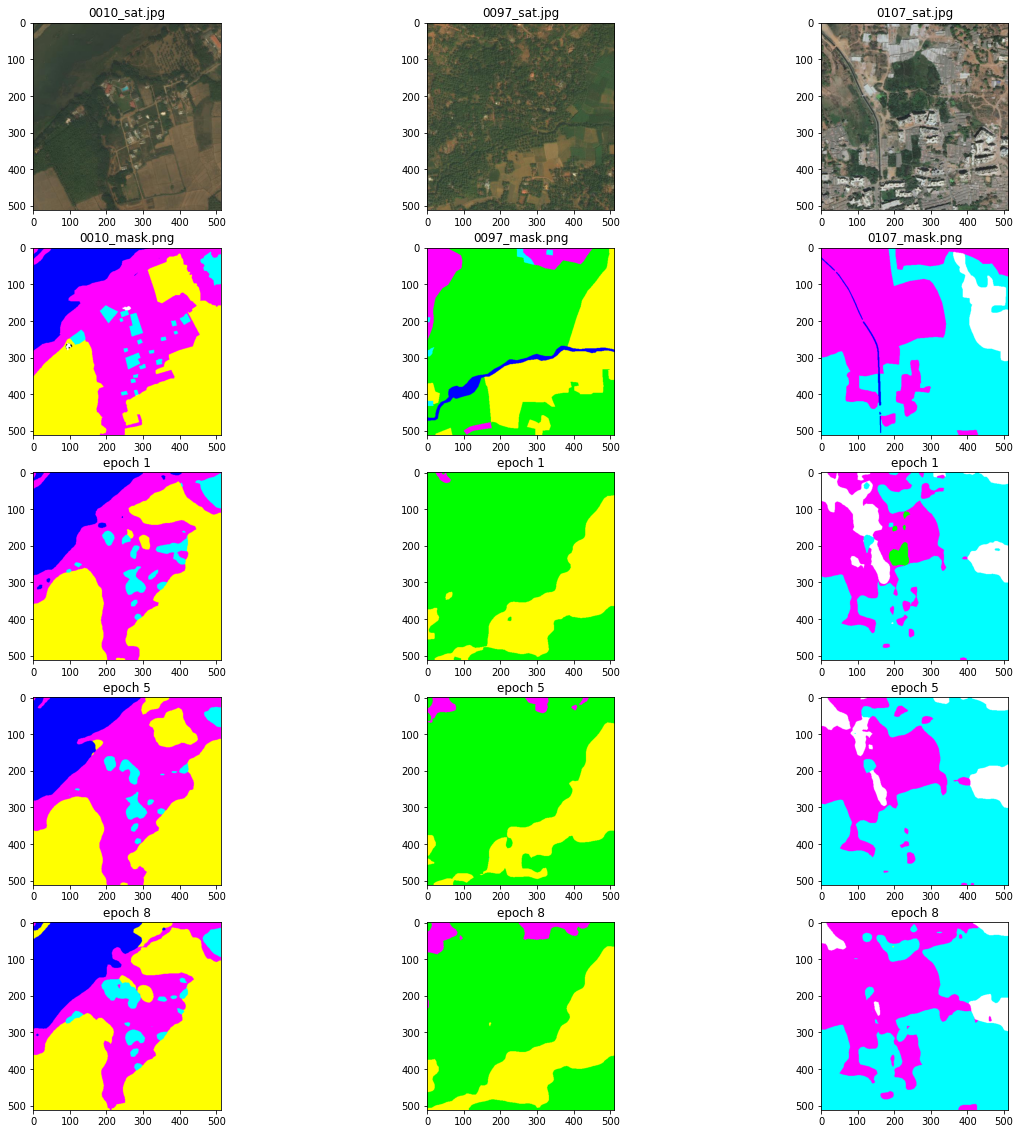

In [65]:
import matplotlib.pyplot as plt

# model1= initialize_model(256, num_classes=7, use_pretrained=True)
# model1.load_state_dict(t.load('/content/drive/MyDrive/HW1/model/Deeplab_0.pth'))

# model5= initialize_model(256, num_classes=7, use_pretrained=True)
# model5.load_state_dict(t.load('/content/drive/MyDrive/HW1/model/Deeplab_5.pth'))

# model8= initialize_model(256, num_classes=7, use_pretrained=True)
# model8.load_state_dict(t.load('/content/drive/MyDrive/HW1/model/Deeplab_8.pth'))

cm = np.array(colormap).astype('uint8')
n = ['0010_sat.jpg', '0097_sat.jpg', '0107_sat.jpg']
m = ['0010_mask.png', '0097_mask.png', '0107_mask.png']

def prediction(network, sample):
  image_data = train_tfm(Image.open('/content/test_data/' + sample))
  image_data = torch.reshape(train_tfm(Image.open('/content/test_data/' + sample)), (1, 3, 512, 512))
  network = network.eval().cuda()
  out = network(image_data.cuda())['out']
  out = F.log_softmax(out, dim=1)
  pre_label = out.max(dim=1)[1].data.cpu().numpy() # logic to label
  return cm[pre_label][0]


fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(5, 3, 1)
ax.imshow(Image.open('/content/test_data/' + n[0]), cmap=plt.cm.bone)
ax.set_title(n[0])
ax =fig.add_subplot(5, 3, 2)
ax.imshow(Image.open('/content/test_data/' + n[1]), cmap=plt.cm.bone)
ax.set_title(n[1])
ax =fig.add_subplot(5, 3, 3)
ax.imshow(Image.open('/content/test_data/' + n[2]), cmap=plt.cm.bone)
ax.set_title(n[2])

ax = fig.add_subplot(5, 3, 4)
ax.imshow(Image.open('/content/test_label/' + m[0]), cmap=plt.cm.bone)
ax.set_title(m[0])
ax =fig.add_subplot(5, 3, 5)
ax.imshow(Image.open('/content/test_label/' + m[1]), cmap=plt.cm.bone)
ax.set_title(m[1])
ax =fig.add_subplot(5, 3, 6)
ax.imshow(Image.open('/content/test_label/' + m[2]), cmap=plt.cm.bone)
ax.set_title(m[2])

for i in range(len(n)):
  ax = fig.add_subplot(5, 3, i + 7)
  ax.imshow(prediction(model1, n[i]), cmap=plt.cm.bone)
  ax.set_title('epoch 1')

for i in range(len(n)):
  ax = fig.add_subplot(5, 3, i + 10)
  ax.imshow(prediction(model5, n[i]), cmap=plt.cm.bone)
  ax.set_title('epoch 5')

for i in range(len(n)):
  ax = fig.add_subplot(5, 3, i + 13)
  ax.imshow(prediction(model8, n[i]), cmap=plt.cm.bone)
  ax.set_title('epoch 8')

# Prediction

In [24]:
train_tfm(Image.open('/content/test_data/' + '0000_sat.jpg')).shape
a = torch.reshape(train_tfm(Image.open('/content/test_data/' + '0000_sat.jpg')), (1, 3, 512, 512))
a.shape

torch.Size([1, 3, 512, 512])

In [17]:
from tqdm import tqdm
from torch import optim
from torch.autograd import Variable
from datetime import datetime
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch as t

BATCH_SIZE = 1
val_data = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True, shuffle=False)

pred = []

net = ensemble.cuda()

net = net.eval()
cm = np.array(colormap).astype('uint8')

for batch_idx, sample in enumerate(tqdm(val_data)):
  valImg = sample['img'].cuda()
  valLabel = sample['label'].cuda()
  print(valImg.shape)
  out = net(valImg)['out']
  out = F.log_softmax(out, dim=1)
  pre_label = out.max(dim=1)[1].data.cpu().numpy() # logic to label
  pred.append(cm[pre_label][0])
  break

  0%|          | 0/257 [00:00<?, ?it/s]

torch.Size([1, 3, 512, 512])


In [ ]:
try:
  os.system('rm -r /content/pred_dir')
except:
  pass

!mkdir /content/pred_dir

In [ ]:
size_tfm = transforms.Compose([
    transforms.Resize((512, 512)),
])

test_label = os.listdir('/content/test_label')
test_label.sort()

for i in range(len(pred)):
  size_tfm(Image.fromarray(pred[i])).save('/content/pred_dir/%s.png'%(test_label[i].split('_')[0]))

In [ ]:
!python3 /content/drive/MyDrive/HW1/mean_iou_evaluate.py -g /content/test_label -p /content/pred_dir

class #0 : 0.77756
class #1 : 0.90861
class #2 : 0.46614
class #3 : 0.81936
class #4 : 0.79977
class #5 : 0.74873

mean_iou: 0.753360



# Training Process

In [ ]:
Image.open()